In [1]:
import os 
import glob
import pathlib
import pickle
import random
import pprint

import matplotlib
%matplotlib inline

import numpy as np
import pandas as pd
import torch
import core.helper.helper_func as hf
from core.model.CrossAttention import CrossAttention
from core.dataset.Epic_pad_Dataset import Epic_pad_Dataset
from core.helper.helper_func import get_bbox_features,evaluate_mAP,Logger,evaluate_k, compute_F1
from core.helper.preprocessing_func import get_img_tensor_no_normalize
import matplotlib.pyplot as plt
import skimage.transform

experiment_dir = "results/epic_kitchens_results/"
pp = pprint.PrettyPrinter(indent=4)
pp.pprint(glob.glob(experiment_dir+'*/'))

newest_experiment = max(glob.glob(experiment_dir+'*/'), key=os.path.getmtime)

n = 12
nth_experiment = sorted(glob.glob(experiment_dir+'*/'), key=os.path.getmtime)[-n]


/home/aniket/anaconda3/envs/thesis/lib/python3.6/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


[   'results/epic_kitchens_results/EpicKitchens_pad_CrossAttention_time_2022_08_19_20_01_05/',
    'results/epic_kitchens_results/EpicKitchens_pad_CrossAttention_time_2022_08_18_05_21_58/',
    'results/epic_kitchens_results/EpicKitchens_pad_CrossAttention_time_2022_08_18_05_23_31/',
    'results/epic_kitchens_results/EpicKitchens_pad_CrossAttention_time_2022_08_19_19_52_31/',
    'results/epic_kitchens_results/EpicKitchens_pad_CrossAttention_time_2022_08_19_20_03_17/',
    'results/epic_kitchens_results/EpicKitchens_pad_CrossAttention_time_2022_08_19_19_45_50/',
    'results/epic_kitchens_results/EpicKitchens_pad_CrossAttention_time_2022_08_19_19_50_33/',
    'results/epic_kitchens_results/EpicKitchens_pad_CrossAttention_time_2022_08_18_05_24_56/',
    'results/epic_kitchens_results/EpicKitchens_pad_CrossAttention_time_2022_08_18_20_30_02/',
    'results/epic_kitchens_results/EpicKitchens_pad_CrossAttention_time_2022_08_19_20_12_48/',
    'results/epic_kitchens_results/EpicKitchens_pa

In [2]:
chosen_experiment = newest_experiment

In [3]:
files = glob.glob(chosen_experiment + "*")
print(files)
with open(chosen_experiment+"config.txt", 'r') as f:
    pp.pprint(f.read())

['results/epic_kitchens_results/EpicKitchens_pad_CrossAttention_time_2022_08_23_17_52_23/config.txt', 'results/epic_kitchens_results/EpicKitchens_pad_CrossAttention_time_2022_08_23_17_52_23/batch_loss.npy', 'results/epic_kitchens_results/EpicKitchens_pad_CrossAttention_time_2022_08_23_17_52_23/model_loss.npy', 'results/epic_kitchens_results/EpicKitchens_pad_CrossAttention_time_2022_08_23_17_52_23/model_MAP.npy', 'results/epic_kitchens_results/EpicKitchens_pad_CrossAttention_time_2022_08_23_17_52_23/model_0_1000.pt', 'results/epic_kitchens_results/EpicKitchens_pad_CrossAttention_time_2022_08_23_17_52_23/model_0_2000.pt', 'results/epic_kitchens_results/EpicKitchens_pad_CrossAttention_time_2022_08_23_17_52_23/model_0_3000.pt', 'results/epic_kitchens_results/EpicKitchens_pad_CrossAttention_time_2022_08_23_17_52_23/model_0_4000.pt', 'results/epic_kitchens_results/EpicKitchens_pad_CrossAttention_time_2022_08_23_17_52_23/model_0_5000.pt', 'results/epic_kitchens_results/EpicKitchens_pad_CrossA

Final_mAP: 0.24243273542600907
Final_loss: 4.7956497227805
Checkpoint loss graph


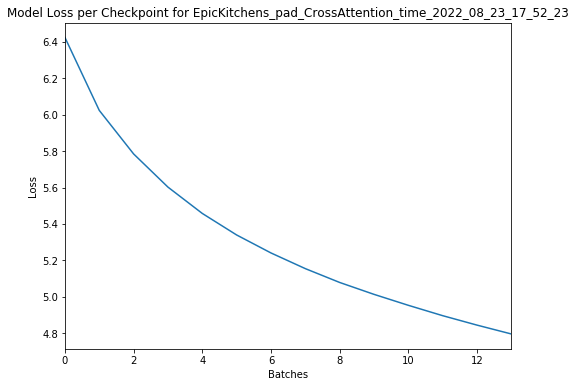

In [4]:
mAP = np.load(chosen_experiment + "model_MAP.npy")
epoch_loss = np.load(chosen_experiment + "model_loss.npy")
batch_loss = np.load(chosen_experiment + "batch_loss.npy") if os.path.exists(chosen_experiment + "batch_loss.npy") else np.array([])

print("Final_mAP: {}".format(mAP[-1]))
print("Final_loss: {}".format(epoch_loss[-1]))

experiment_name = os.path.basename(os.path.normpath(chosen_experiment))

if np.any(epoch_loss):
    print("Checkpoint loss graph")
    s_e_loss = pd.Series(epoch_loss, name="Checkpoint Loss (28 images)").plot(figsize=(8,6), title="Model Loss per Checkpoint for {}".format(experiment_name))
    s_e_loss.set_xlabel("Batches")
    s_e_loss.set_ylabel("Loss")
    
    f_e = s_e_loss.get_figure()
    f_e.savefig("results/{}_checkpoint_loss.png".format(experiment_name))



Batch loss graph


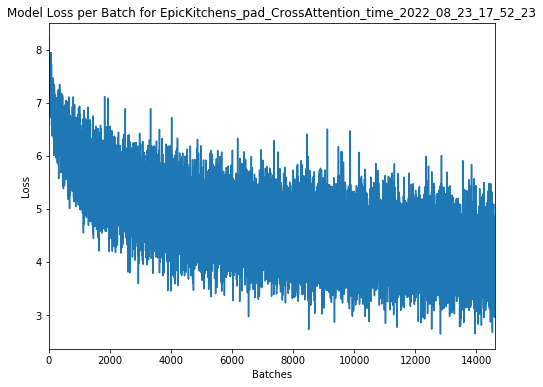

In [5]:
if np.any(batch_loss):
    print("Batch loss graph")
    s_b_loss = pd.Series(batch_loss, name="Batch Loss (28 images)").plot(figsize=(8,6), title="Model Loss per Batch for {}".format(experiment_name))
    s_b_loss.set_xlabel("Batches")
    s_b_loss.set_ylabel("Loss")
    f_b = s_b_loss.get_figure()
    f_b.savefig("results/{}_batch_loss.png".format(experiment_name))

In [6]:
with open('./w2v/epic_kitchens_act_obj.pkl','rb') as f:
    content = pickle.load(f)

    
batch_size = 30
val_Dataset = Epic_pad_Dataset('validation',content)
subset_val = torch.utils.data.Subset(val_Dataset, random.sample(list(range(len(val_Dataset))), len(val_Dataset) // 5))
test_dataloader = torch.utils.data.DataLoader(subset_val,
                                              batch_size=batch_size, shuffle=False,
                                              num_workers=4)

last_model = max(glob.glob(chosen_experiment +'*.pt'), key=os.path.getmtime)
print(last_model)

idx_gpu = 2
device = torch.device("cuda:{}".format(idx_gpu) if torch.cuda.is_available() else "cpu")


model = CrossAttention(dim_f=2048,dim_v=300,
                       init_w2v_a=content['actions_w2v'],init_w2v_o=content['objects_w2v'],
                       Z_a=content['Z_a'],Z_o=content['Z_o'],
                       trainable_w2v_a = True,trainable_w2v_o = True,
                       normalize_V_a = True, normalize_V_o = True, normalize_F = True,
                       label_type = "interaction", grid_size=val_Dataset.grid_size,
                       lamb = -1, is_w2v_map = True)

model.to(device)
model.load_state_dict(torch.load(last_model,map_location=device))
model.eval()

len features validation: 71278
results/epic_kitchens_results/EpicKitchens_pad_CrossAttention_time_2022_08_23_17_52_23/model_0_14000.pt
RELU
RELU
RELU
------------------------------
Configuration
lamb -1
normalize V_a
normalize V_o
normalize F


CrossAttention(
  (w2v_map): ResNet(
    (linear1): Linear(in_features=300, out_features=60, bias=True)
    (linear2): Linear(in_features=60, out_features=300, bias=True)
  )
  (log_softmax_func): LogSoftmax()
  (bce_criterion): BCEWithLogitsLoss()
  (ce_criterion): CrossEntropyLoss()
  (object2actor_gaussian): NeuralNet(
    (linear1): Linear(in_features=2350, out_features=300, bias=True)
    (linear2): Linear(in_features=300, out_features=4, bias=True)
  )
  (actor2object_gaussian): NeuralNet(
    (linear1): Linear(in_features=2350, out_features=300, bias=True)
    (linear2): Linear(in_features=300, out_features=4, bias=True)
  )
)

In [7]:
AP,all_preds,all_labels=evaluate_mAP(test_dataloader,model,device)

100%|██████████| 476/476 [05:37<00:00,  1.41it/s]


realistic


In [8]:
print("Validation AP: {}".format(np.mean(AP)))
y_pred_y_true = [(np.argmax(x),np.argmax(y)) for i,(x,y) in enumerate(zip(all_preds, all_labels))]
matching_indices = [i for i,(x,y) in enumerate(zip(all_preds, all_labels)) if np.argmax(x) == np.argmax(y)]
incorrect_indices = [i for i,(x,y) in enumerate(zip(all_preds, all_labels)) if np.argmax(x) != np.argmax(y)]
max_values_pred = [(i, np.argmax(x), np.max(x)) for i,x in enumerate(all_preds)]
correct_max_values_pred = [max_values_pred[i] for i in matching_indices]
correct_datapoints = [subset_val[i] for i in matching_indices]
incorrect_datapoints = [subset_val[i] for i in incorrect_indices]

Validation AP: 0.27774663677130057


In [9]:
hoi_df = pd.read_csv("data/epic_kitchens/epic_kitchens_hoi.csv")
noun_df = pd.read_csv("data/epic_kitchens/epic-kitchens-100-annotations/EPIC_100_noun_classes.csv")
action_df = pd.read_csv("data/epic_kitchens/epic-kitchens-100-annotations/EPIC_100_verb_classes.csv")

In [10]:
hoi_df["verb_key"] = np.array([action_df["key"][action_df["id"] == i].values for i in hoi_df["verb_class"].values])

In [11]:
hoi_df["noun_key"] = np.array([noun_df["key"][noun_df["id"] == i].values for i in hoi_df["noun_class"].values])

In [12]:
def visualize_attention(img_ids,A_o,A_a,labels,df_hoi,img_dir,save_path=None,prefix=''):          #A: [bkr]
     
    if (save_path is not None) and (not os.path.isdir(save_path)):
        os.mkdir(save_path)
    
    n = len(img_ids)        #pytorch only convert numerical value to tensor, string values are kept at their orginal types
    
    A_o = A_o.cpu().detach().numpy()             #convert to numpy cpu format
    A_a = A_a.cpu().detach().numpy()             #convert to numpy cpu format
    
#     labels = labels.cpu().numpy()
    
    image_size = 14*16          #one side of the img
    r = A_o.shape[2]
    h = w =  int(np.sqrt(r))
    
    ret_idxs_pos = []
    for i in range(n):
        feature_file=img_ids[i]
        print(feature_file)
        img_video = feature_file.split("_")[:2]
        img_video = "_".join(img_video)
        
        img_name=feature_file.split("_")[2:]#.decode('utf-8')
        img_name = "_".join(img_name)
        img_name = img_name.split(".")[0]
        img_name = img_name+".jpg"
        
        print("Video: {}, Frame: {}".format(img_video, img_name))
        
#        visualize_dir = save_path+img_name+'/'
#       
        
        alpha_o = A_o[i]                #[kr]
        alpha_a = A_a[i]                #[kr]
        print("a_o: {}, a_a:{}".format(alpha_o.shape, alpha_a.shape))
        label = labels[i]           #[k]
        # Plot original image
        image = get_img_tensor_no_normalize("{}/{}/{}".format(img_dir, img_video, img_name))
        image = image.permute(1,2,0) #[224,244,3] <== [3,224,224] 

        idxs_pos = np.where(label==1)[0]
        print(idxs_pos)
        n_pos = len(idxs_pos)
        fig=plt.figure('',figsize=(10, 10))
        
        ret_idxs_pos.append(idxs_pos)
        
        for idx_r,idx_l in enumerate(idxs_pos):
            ax = plt.subplot(n_pos, 3, (idx_r*3)+1)
            plt.imshow(image)
            plt.axis('off')
            ax.set_title(img_name,{'fontsize': 10})
            
            ax = plt.subplot(n_pos, 3, (idx_r*3)+2)
            plt.imshow(image)
            alp_curr_o = alpha_o[idx_l,:].reshape(17,17)
            alp_img = skimage.transform.pyramid_expand(alp_curr_o, upscale=image_size/h, sigma=10,multichannel=False)
            plt.imshow(alp_img, alpha=0.7)
            plt.axis('off')
            ax.set_title("{}".format(df_hoi.iloc[idx_l]['noun_key']),{'fontsize': 10})
            
            ax = plt.subplot(n_pos, 3, (idx_r*3)+3)
            plt.imshow(image)
            alp_curr_a = alpha_a[idx_l,:].reshape(17,17)
            alp_img = skimage.transform.pyramid_expand(alp_curr_a, upscale=image_size/h, sigma=10,multichannel=False)
            plt.imshow(alp_img, alpha=0.7)
            plt.axis('off')
            ax.set_title("{}".format(df_hoi.iloc[idx_l]['verb_key']),{'fontsize': 10})
        fig.tight_layout()
        if save_path is not None:
            plt.savefig(save_path+prefix+img_name,dpi=500)
            plt.show()
        else:
            plt.show()
            
    return ret_idxs_pos

In [13]:
n = 3

img_files = [os.path.basename(correct_datapoints[i][0]) for i in range(n)]
img_features = [correct_datapoints[i][1] for i in range(n)]
img_labels = np.array([correct_datapoints[i][2] for i in range(n)])
features = torch.tensor(img_features).to(device)
output = model(features)

In [14]:
output.keys()

dict_keys(['s', 'e_a', 'e_o', 'A_o', 'A_a', 'A_o_log', 'A_a_log', 'positions_o', 'positions_a', 'Masks_o', 'Masks_a', 'means_a', 'std_variances_a', 'means_o', 'std_variances_o', 's_cross', 's_self'])

P13_03_frame_0000011893.pkl.gz
Video: P13_03, Frame: frame_0000011893.jpg
a_o: (3568, 289), a_a:(3568, 289)
[1369]


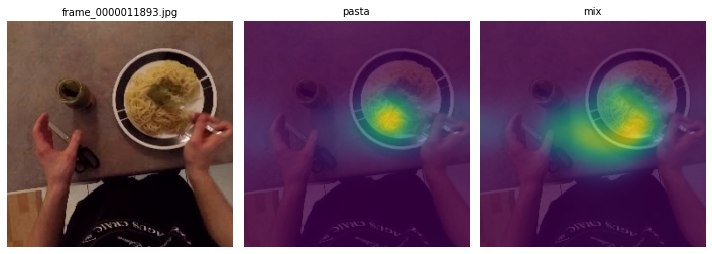

P11_24_frame_0000000364.pkl.gz
Video: P11_24, Frame: frame_0000000364.jpg
a_o: (3568, 289), a_a:(3568, 289)
[663]


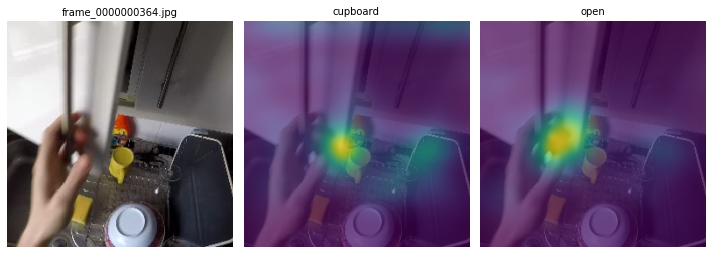

P30_08_frame_0000007311.pkl.gz
Video: P30_08, Frame: frame_0000007311.jpg
a_o: (3568, 289), a_a:(3568, 289)
[5]


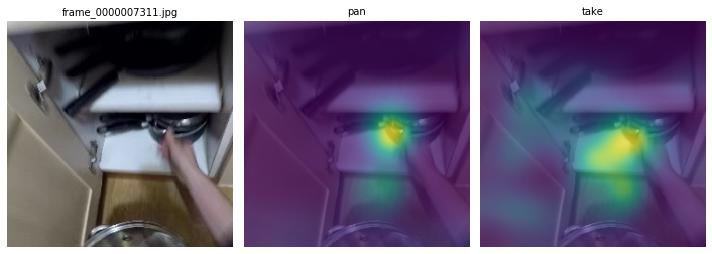

[array([1369]), array([663]), array([5])]

In [15]:
### Correct Guesses

visualize_attention(img_files, output["A_o"], output["A_a"], img_labels, hoi_df, "data/epic_kitchens/epic_images", save_path="results/attention_map_viz/", prefix="correct_attention_map_viz_")

In [16]:
n = 6

img_files = [os.path.basename(incorrect_datapoints[i][0]) for i in range(n)]
img_features = [incorrect_datapoints[i][1] for i in range(n)]
img_labels = np.array([incorrect_datapoints[i][2] for i in range(n)])
features = torch.tensor(img_features).to(device)
output = model(features)

P32_01_frame_0000004615.pkl.gz
Video: P32_01, Frame: frame_0000004615.jpg
a_o: (3568, 289), a_a:(3568, 289)
[99]


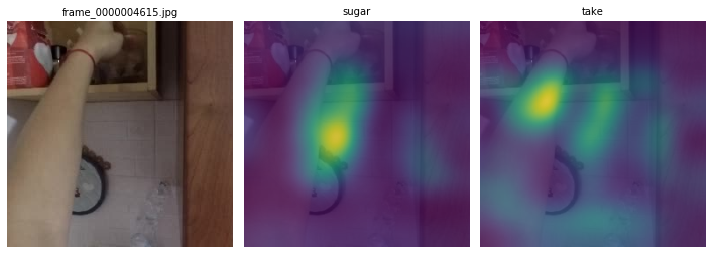

P01_11_frame_0000022749.pkl.gz
Video: P01_11, Frame: frame_0000022749.jpg
a_o: (3568, 289), a_a:(3568, 289)
[558]


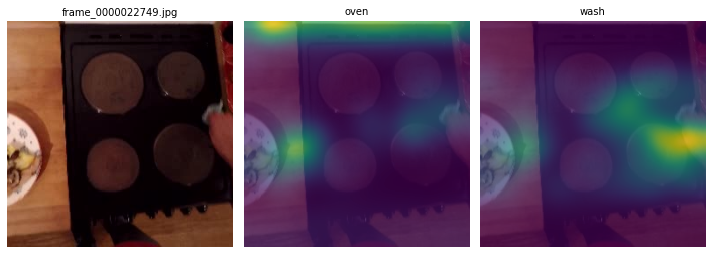

P01_14_frame_0000066515.pkl.gz
Video: P01_14, Frame: frame_0000066515.jpg
a_o: (3568, 289), a_a:(3568, 289)
[671]


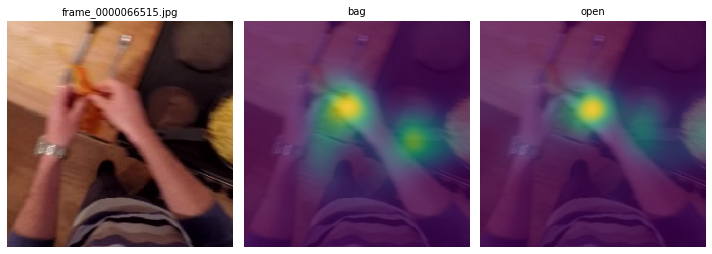

P18_05_frame_0000019915.pkl.gz
Video: P18_05, Frame: frame_0000019915.jpg
a_o: (3568, 289), a_a:(3568, 289)
[556]


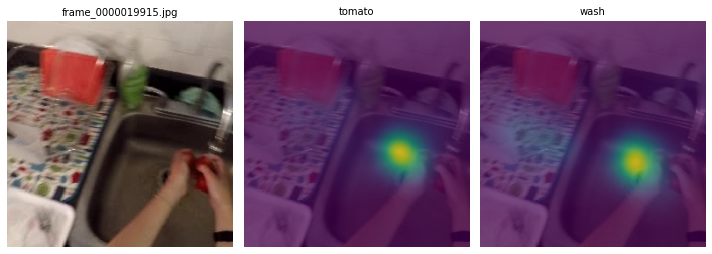

P24_09_frame_0000030842.pkl.gz
Video: P24_09, Frame: frame_0000030842.jpg
a_o: (3568, 289), a_a:(3568, 289)
[1360]


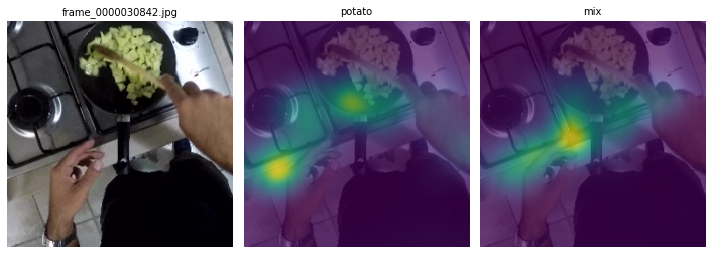

P32_10_frame_0000021823.pkl.gz
Video: P32_10, Frame: frame_0000021823.jpg
a_o: (3568, 289), a_a:(3568, 289)
[2073]


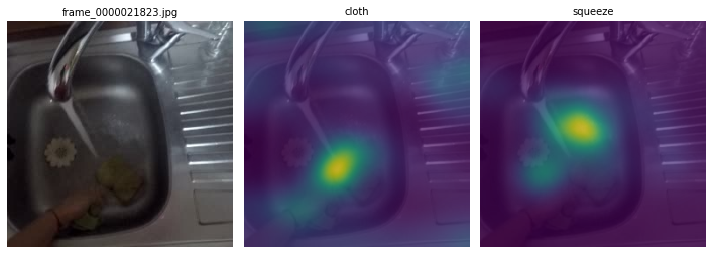

[array([99]),
 array([558]),
 array([671]),
 array([556]),
 array([1360]),
 array([2073])]

In [18]:
### Incorrect Guesses

visualize_attention(img_files, output["A_o"], output["A_a"], img_labels, hoi_df, "data/epic_kitchens/epic_images", save_path="results/attention_map_viz/", prefix="incorrect_attention_map_viz_")